In [134]:
import numpy as np # calculations with arrays
import pandas as pd # user-friendly DataFrames for data representation
import sklearn # machine learning algorithms
from sklearn import ensemble, linear_model, cross_validation, grid_search
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer as DV
import xgboost as xgboost
import matplotlib.pyplot as plt # import plot functions
# necessary to plot in jupyter notebook:
%matplotlib inline
import seaborn as sns # make plots beautiful
import math
import time, datetime

In [135]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%d %H:%M:%S')

In [193]:
transactions = pd.read_csv('transactions.csv')

In [137]:
train_transactions = transactions[transactions.amount < 0].copy()
train_transactions['day'] = train_transactions.tr_datetime.apply(lambda dt: dt.split()[0]).astype(int)

In [138]:
train_transactions.head()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,day
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN,0
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN,1
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN,1
4,39026145,2 15:33:42,5499,1010,-920.83,NaN,2
5,39026145,2 15:53:49,5541,1010,-14643.37,NaN,2


In [139]:
def todate(day):
    return datetime.timedelta(days=day)+datetime.date(2015,8,1)

In [140]:
train_transactions['date'] = pd.to_datetime(train_transactions.day.apply(todate))

In [141]:
train_transactions['date'][:4]

0   2015-08-01
2   2015-08-02
3   2015-08-02
4   2015-08-03
Name: date, dtype: datetime64[ns]

In [142]:
train_transactions.head()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,day,date
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN,0,2015-08-01
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN,1,2015-08-02
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN,1,2015-08-02
4,39026145,2 15:33:42,5499,1010,-920.83,NaN,2,2015-08-03
5,39026145,2 15:53:49,5541,1010,-14643.37,NaN,2,2015-08-03


In [147]:
date_and_sum_train = train_transactions.groupby(['date']).amount.sum())

In [148]:
date_and_sum_train.head()

,amount
date,
2015-08-01,-6.861654e+08
2015-08-02,-4.312505e+08
2015-08-03,-3.510783e+08
2015-08-04,-6.345417e+08
2015-08-05,-6.841690e+08


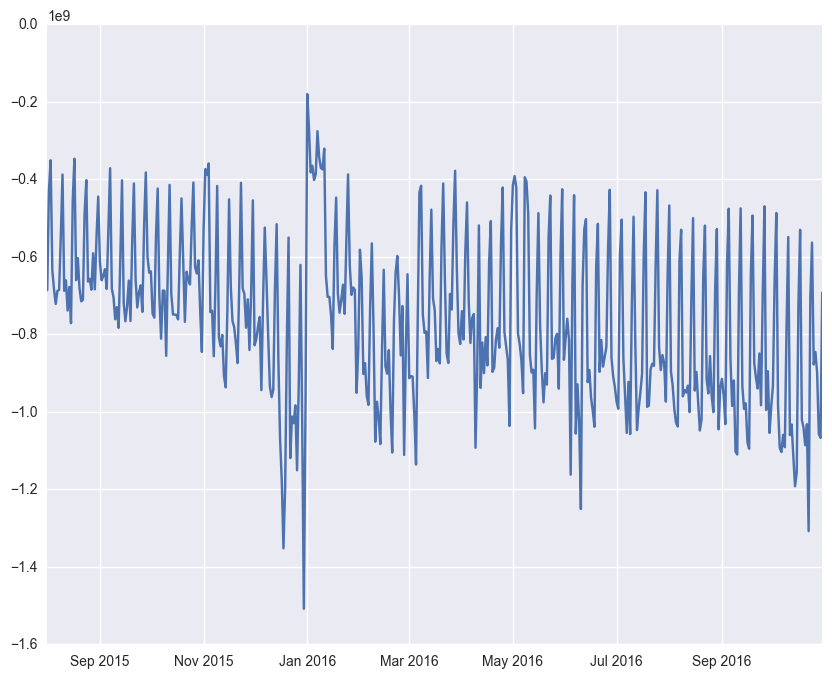

In [158]:
plt.figure(figsize = (10,8))
plt.plot(date_and_sum_train)

In [168]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    plt.figure(figsize=(11,7))
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


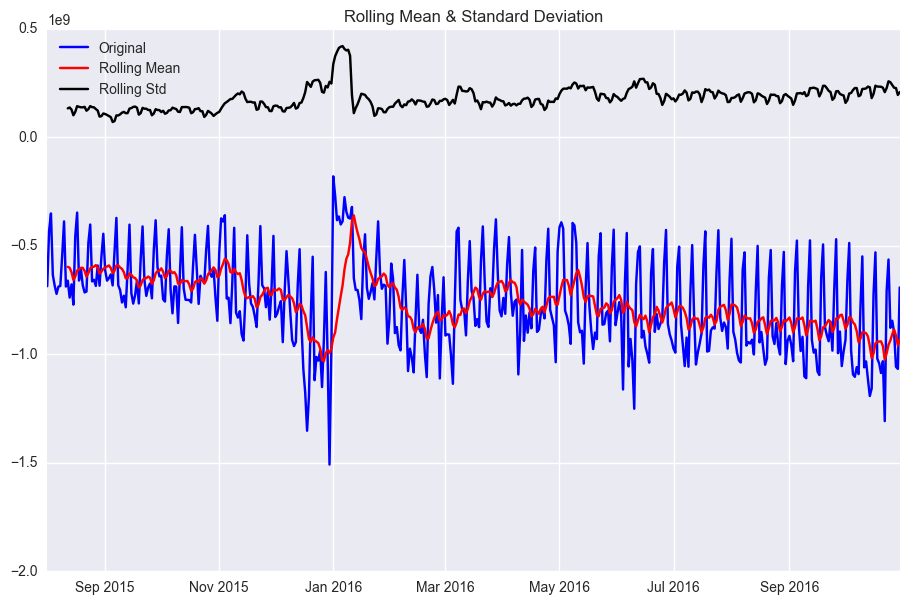

Results of Dickey-Fuller Test:
Test Statistic                  -3.290248
p-value                          0.015320
#Lags Used                      15.000000
Number of Observations Used    441.000000
Critical Value (5%)             -2.868116
Critical Value (1%)             -3.445266
Critical Value (10%)            -2.570273
dtype: float64


In [169]:
test_stationarity(date_and_sum_train.amount)

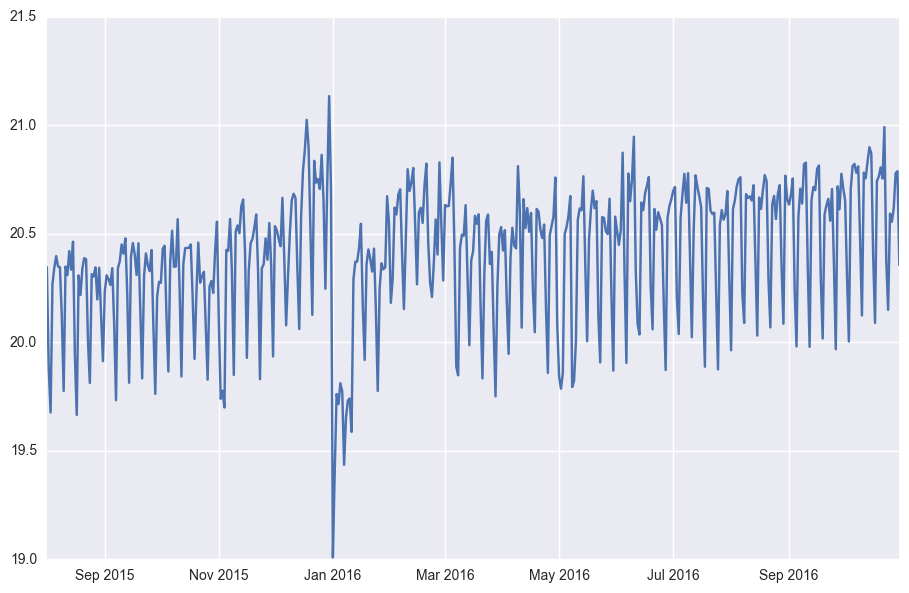

In [173]:
ts_log = np.log(-date_and_sum_train)
plt.figure(figsize=(11,7))
plt.plot(ts_log)

/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
  if __name__ == '__main__':


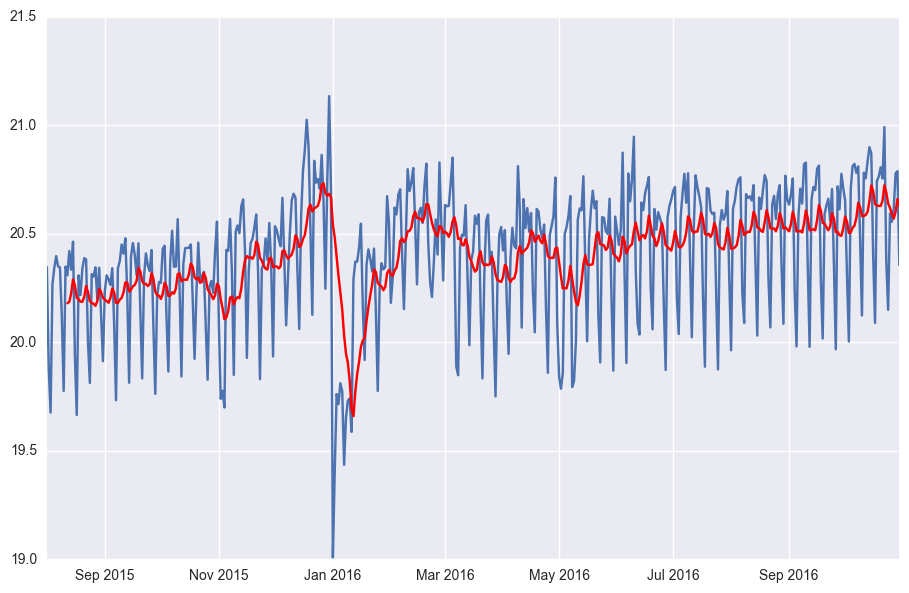

In [175]:
moving_avg = pd.rolling_mean(ts_log,12)
plt.figure(figsize=(11,7))
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [176]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)


,amount
date,
2015-08-01,NaN
2015-08-02,NaN
2015-08-03,NaN
2015-08-04,NaN
2015-08-05,NaN
2015-08-06,NaN
2015-08-07,NaN
2015-08-08,NaN
2015-08-09,NaN


/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


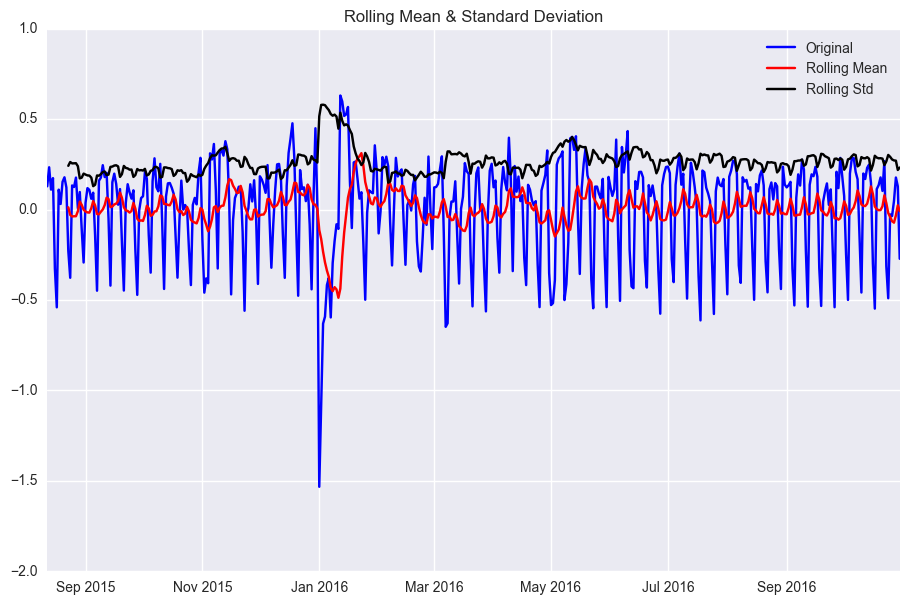

Results of Dickey-Fuller Test:
Test Statistic                -6.747119e+00
p-value                        3.015340e-09
#Lags Used                     1.400000e+01
Number of Observations Used    4.310000e+02
Critical Value (5%)           -2.868269e+00
Critical Value (1%)           -3.445614e+00
Critical Value (10%)          -2.570354e+00
dtype: float64


In [178]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff.amount)

/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(halflife=12,ignore_na=False,min_periods=0,adjust=True).mean()
  if __name__ == '__main__':


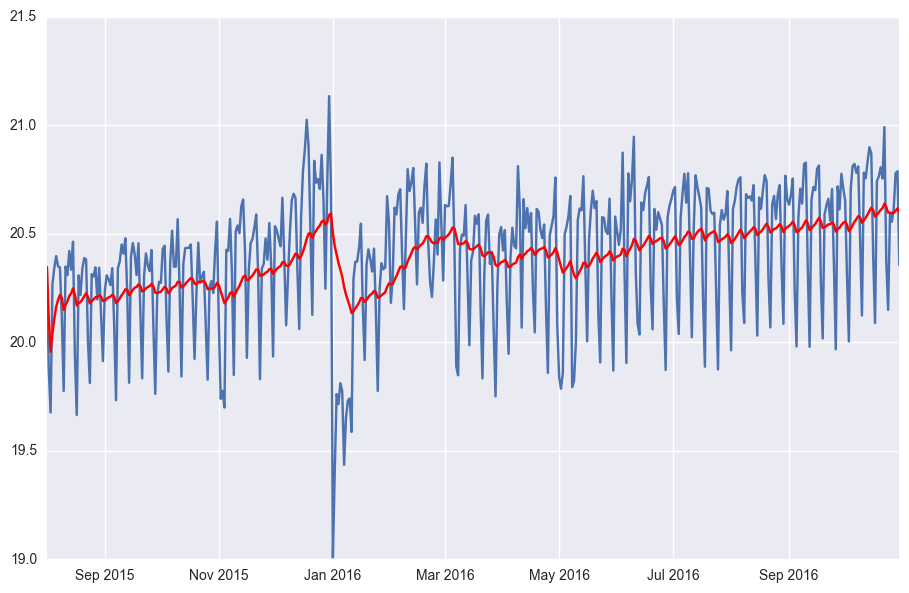

In [180]:
expwighted_avg = pd.ewma(ts_log, halflife=12)
plt.figure(figsize=(11,7))
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


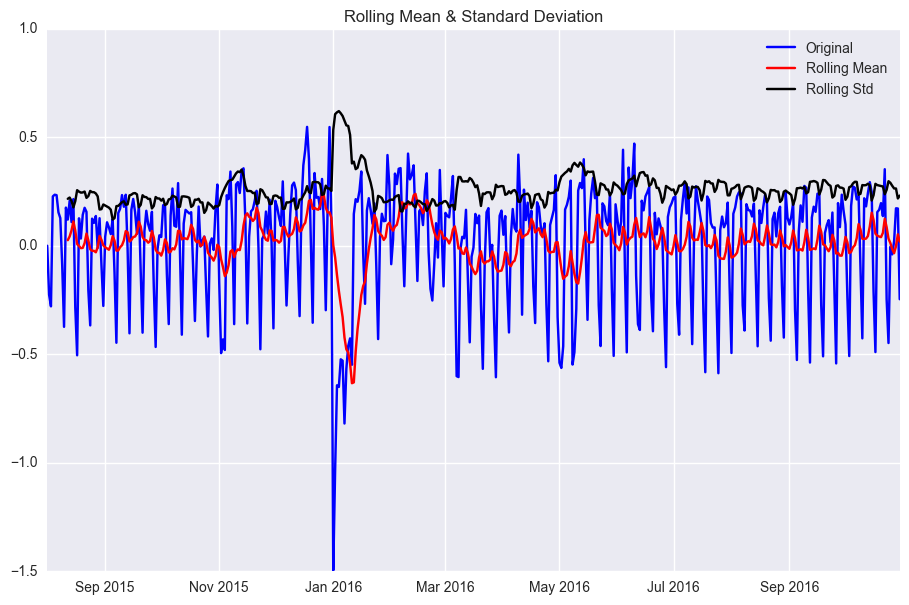

Results of Dickey-Fuller Test:
Test Statistic                -5.852432e+00
p-value                        3.563422e-07
#Lags Used                     1.400000e+01
Number of Observations Used    4.420000e+02
Critical Value (5%)           -2.868101e+00
Critical Value (1%)           -3.445232e+00
Critical Value (10%)          -2.570265e+00
dtype: float64


In [181]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff.amount)

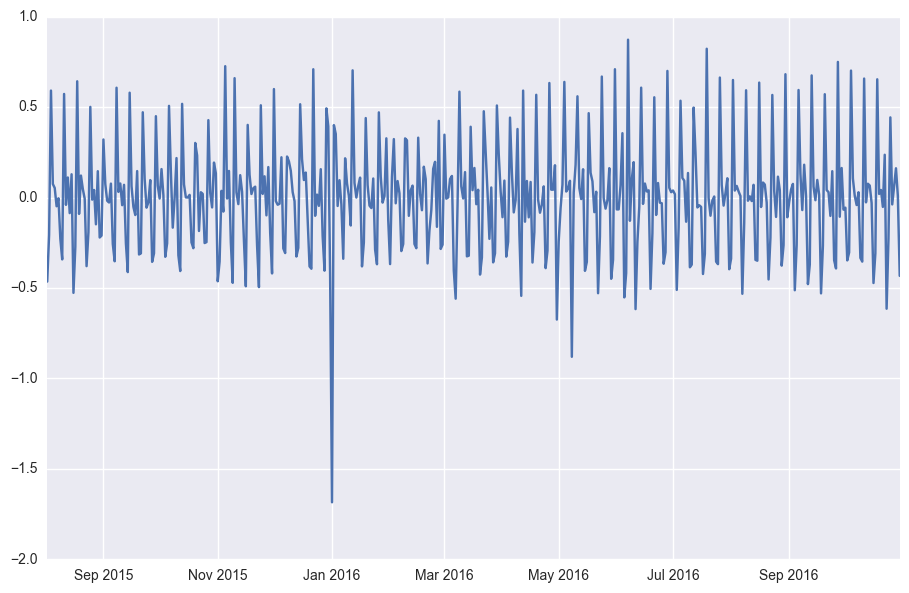

In [183]:
ts_log_diff = ts_log - ts_log.shift()
plt.figure(figsize=(11,7))
plt.plot(ts_log_diff)

/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


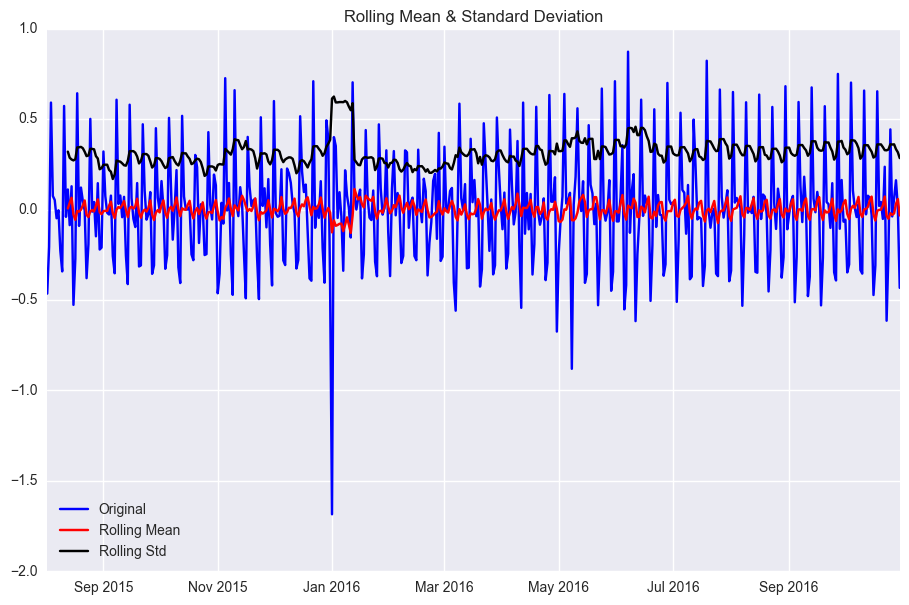

Results of Dickey-Fuller Test:
Test Statistic                -7.613915e+00
p-value                        2.217646e-11
#Lags Used                     1.400000e+01
Number of Observations Used    4.410000e+02
Critical Value (5%)           -2.868116e+00
Critical Value (1%)           -3.445266e+00
Critical Value (10%)          -2.570273e+00
dtype: float64


In [184]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff.amount)

In [191]:
ts_log.head()

,amount
date,
2015-08-01,20.346629
2015-08-02,19.882200
2015-08-03,19.676520
2015-08-04,20.268414
2015-08-05,20.343716


In [192]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log.amount)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


ValueError: freq D not understood. Please report if you think this in error.

In [122]:
test_transactions = pd.DataFrame(columns=train_transactions.mcc_code.unique(), 
                                 index=np.arange(1, 31) + train_transactions.day.max())
test_transactions = test_transactions.unstack().reset_index().dropna(axis=1)
test_transactions.columns = ['mcc_code', 'day']

In [123]:
test_transactions.head()

,mcc_code,data
0,4814,457
1,4814,458
2,4814,459
3,4814,460
4,4814,461


In [7]:
test_transactions.day.max()

486

In [8]:
train_grid = pd.DataFrame(columns=train_transactions.mcc_code.unique(), 
                          index=train_transactions.day.unique())
train_grid.head()

,4814,4829,5499,5541,5200,5732,6011,5331,5912,5411,...,8699,7216,5451,5967,7338,9402,5697,1731,5940,9211
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
train_grid.shape

(457, 184)

In [14]:
train_grid = train_grid.unstack().reset_index().dropna(axis=1)
train_grid.head()

,level_0,level_1
0,4814,0
1,4814,1
2,4814,2
3,4814,3
4,4814,4


In [15]:
train_grid.columns = ['mcc_code', 'day']

In [16]:
train_grid.head()

,mcc_code,day
0,4814,0
1,4814,1
2,4814,2
3,4814,3
4,4814,4


In [34]:
day_in_month = {0: 31, 1: 30, 2:31, 3:30, 4:31, 5:31, 6:28, 7:31, \
               8:30, 9:31, 10:30, 11:31, 12:31, 13:30, 14:31, 15:30, 16:31, 17:30 }

In [35]:
month_inf = pd.DataFrame(day_in_month, index=np.arange(1)).T.reset_index()
month_inf.columns = ['num_month', 'days']
month_inf.head()

,num_month,days
0,0,31
1,1,30
2,2,31
3,3,30
4,4,31


In [49]:
for tr_table in [train_transactions, test_transactions, train_grid]:
    

    df_1 = tr_table[tr_table['day'] < 31]
    df_1['week_num'] = df_1['day'] // 7
    df_1['week_day'] = df_1['day'] %7
    df_1['month_num'] = 0
    df_1['month_day'] = tr_table['day'] % 31

    df_2 = tr_table[(tr_table['day'] < 61) & (tr_table['day']>=31) ]
    df_2['week_num'] = df_2['day'] // 7
    df_2['week_day'] = df_2['day'] %7
    df_2['month_num'] = 1
    df_2['month_day'] = tr_table['day'] % 30

    df_3 = tr_table[(tr_table['day'] < 92) & (tr_table['day'] >= 61)]
    df_3['week_num'] = df_3['day'] // 7
    df_3['week_day'] = df_3['day'] %7
    df_3['month_num'] = 2
    df_3['month_day'] = tr_table['day'] % 31
    
    df_4 = tr_table[(tr_table['day'] < 122) & (tr_table['day'] >= 92)]
    df_4['week_num'] = df_4['day'] // 7
    df_4['week_day'] = df_4['day'] %7
    df_4['month_num'] = 3
    df_4['month_day'] = tr_table['day'] % 30

    df_5 = tr_table[(tr_table['day'] < 153) & (tr_table['day'] >= 122)]
    df_5['week_num'] = df_5['day'] // 7
    df_5['week_day'] = df_5['day'] %7
    df_5['month_num'] = 4
    df_5['month_day'] = tr_table['day'] % 31
    
    df_6 = tr_table[(tr_table['day'] < 184) & (tr_table['day'] >= 153)]
    df_6['week_num'] = df_6['day'] // 7
    df_6['week_day'] = df_6['day'] %7
    df_6['month_num'] = 5
    df_6['month_day'] = tr_table['day'] % 31
    
    df_7 = tr_table[(tr_table['day'] < 212) & (tr_table['day'] >= 184)]
    df_7['week_num'] = df_7['day'] // 7
    df_7['week_day'] = df_7['day'] %7
    df_7['month_num'] = 6
    df_7['month_day'] = tr_table['day'] % 28
    
    df_8 = tr_table[(tr_table['day'] < 243) & (tr_table['day'] >= 212)]
    df_8['week_num'] = df_8['day'] // 7
    df_8['week_day'] = df_8['day'] %7
    df_8['month_num'] = 7
    df_8['month_day'] = tr_table['day'] % 31
    
    df_9 = tr_table[(tr_table['day'] < 273) & (tr_table['day'] >= 243)]
    df_9['week_num'] = df_9['day'] // 7
    df_9['week_day'] = df_9['day'] %7
    df_9['month_num'] = 8
    df_9['month_day'] = tr_table['day'] % 30
        
    df_10 = tr_table[(tr_table['day'] < 304) & (tr_table['day'] >= 273)]
    df_10['week_num'] = df_10['day'] // 7
    df_10['week_day'] = df_10['day'] %7
    df_10['month_num'] = 9
    df_10['month_day'] = tr_table['day'] % 31
    
    df_11 = tr_table[(tr_table['day'] < 334) & (tr_table['day'] >= 304)]
    df_11['week_num'] = df_11['day'] // 7
    df_11['week_day'] = df_11['day'] %7
    df_11['month_num'] = 10
    df_11['month_day'] = tr_table['day'] % 30
    
    df_12 = tr_table[(tr_table['day'] < 365) & (tr_table['day'] >= 334)]
    df_12['week_num'] = df_12['day'] // 7
    df_12['week_day'] = df_12['day'] %7
    df_12['month_num'] = 11
    df_12['month_day'] = tr_table['day'] % 31
    
    df_13 = tr_table[(tr_table['day'] < 396) & (tr_table['day'] >= 365)]
    df_13['week_num'] = df_13['day'] // 7
    df_13['week_day'] = df_13['day'] %7
    df_13['month_num'] = 12
    df_13['month_day'] = tr_table['day'] % 31
    
    df_14 = tr_table[(tr_table['day'] < 426) & (tr_table['day'] >= 396)]
    df_14['week_num'] = df_14['day'] // 7
    df_14['week_day'] = df_14['day'] %7
    df_14['month_num'] = 13
    df_14['month_day'] = tr_table['day'] % 30
        
    df_15 = tr_table[(tr_table['day'] < 457) & (tr_table['day'] >= 426)]
    df_15['week_num'] = df_15['day'] // 7
    df_15['week_day'] = df_15['day'] %7
    df_15['month_num'] = 14
    df_15['month_day'] = tr_table['day'] % 31
    
    df_16 = tr_table[(tr_table['day'] < 487) & (tr_table['day'] >= 457)]
    df_16['week_num'] = df_16['day'] // 7
    df_16['week_day'] = df_16['day'] %7
    df_16['month_num'] = 15
    df_16['month_day'] = tr_table['day'] % 30
    
    
    tr_table = pd.concat([df_1, df_2, df_3, df_4, df_5, \
                         df_6, df_7, df_8, df_9, df_10,\
                         df_11, df_12, df_13, df_14, df_15, df_16], axis = 0)

    

/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

In [50]:
print df_1.shape
print train_grid.shape

(5704, 6)
(84088, 6)


In [53]:
train_transactions.head()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,day,week_num,week_day,month_num,month_day
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN,0,0,0,0,0
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN,1,0,1,0,1
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN,1,0,1,0,1
4,39026145,2 15:33:42,5499,1010,-920.83,NaN,2,0,2,0,2
5,39026145,2 15:53:49,5541,1010,-14643.37,NaN,2,0,2,0,2


In [54]:
train_transactions = \
    pd.merge(train_grid,
             train_transactions.groupby(['day', 'week_num', 'week_day', 'month_num', 'month_day', 'mcc_code',])[['amount']]\
                 .sum().reset_index(),
             how='left').fillna(0)

In [55]:
train_transactions.head()

,mcc_code,day,week_num,week_day,month_num,month_day,amount
0,4814,0,0,0,0,0,-11098744.26
1,4814,1,0,1,0,1,-7881825.53
2,4814,2,0,2,0,2,-6777480.45
3,4814,3,0,3,0,3,-9277943.73
4,4814,4,0,4,0,4,-9999757.21


In [56]:
train_transactions.month_num.unique()[1:]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [57]:
for day_shift in [ 0, 1, 2, 3, 4, 5, 6, 7]:
    for month_shift in train_transactions.month_num.unique()[1:]:
        train_shift = train_transactions.copy()
        train_shift['month_num'] += month_shift
        train_shift['month_day'] += day_shift
        train_shift['amount_day_{}_{}'.format(day_shift, month_shift)] = np.log(-train_shift['amount'] + 1)
        train_shift = train_shift[['month_num', 'month_day', 'mcc_code', 'amount_day_{}_{}'.format(day_shift, month_shift)]]

        train_transactions = pd.merge(train_transactions, train_shift, 
                                      on=['month_num', 'month_day', 'mcc_code'], how='left').fillna(0)
        test_transactions = pd.merge(test_transactions, train_shift, 
                                     on=['month_num', 'month_day', 'mcc_code'], how='left').fillna(0)
    print day_shift

0
1
2
3
4
5
6
7


In [58]:
train_shift.head()

,month_num,month_day,mcc_code,amount_day_7_15
0,15,7,4814,16.222343
1,15,8,4814,15.880070
2,15,9,4814,15.729116
3,15,10,4814,16.043151
4,15,11,4814,16.118071


In [59]:
list(train_transactions.columns)

['mcc_code',
 'day',
 'week_num',
 'week_day',
 'month_num',
 'month_day',
 'amount',
 'amount_day_0_1',
 'amount_day_0_2',
 'amount_day_0_3',
 'amount_day_0_4',
 'amount_day_0_5',
 'amount_day_0_6',
 'amount_day_0_7',
 'amount_day_0_8',
 'amount_day_0_9',
 'amount_day_0_10',
 'amount_day_0_11',
 'amount_day_0_12',
 'amount_day_0_13',
 'amount_day_0_14',
 'amount_day_0_15',
 'amount_day_1_1',
 'amount_day_1_2',
 'amount_day_1_3',
 'amount_day_1_4',
 'amount_day_1_5',
 'amount_day_1_6',
 'amount_day_1_7',
 'amount_day_1_8',
 'amount_day_1_9',
 'amount_day_1_10',
 'amount_day_1_11',
 'amount_day_1_12',
 'amount_day_1_13',
 'amount_day_1_14',
 'amount_day_1_15',
 'amount_day_2_1',
 'amount_day_2_2',
 'amount_day_2_3',
 'amount_day_2_4',
 'amount_day_2_5',
 'amount_day_2_6',
 'amount_day_2_7',
 'amount_day_2_8',
 'amount_day_2_9',
 'amount_day_2_10',
 'amount_day_2_11',
 'amount_day_2_12',
 'amount_day_2_13',
 'amount_day_2_14',
 'amount_day_2_15',
 'amount_day_3_1',
 'amount_day_3_2',
 'a

In [60]:
shift = 500

In [61]:
train_transactions.head()

,mcc_code,day,week_num,week_day,month_num,month_day,amount,amount_day_0_1,amount_day_0_2,amount_day_0_3,...,amount_day_7_6,amount_day_7_7,amount_day_7_8,amount_day_7_9,amount_day_7_10,amount_day_7_11,amount_day_7_12,amount_day_7_13,amount_day_7_14,amount_day_7_15
0,4814,0,0,0,0,0,-11098744.26,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4814,1,0,1,0,1,-7881825.53,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4814,2,0,2,0,2,-6777480.45,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4814,3,0,3,0,3,-9277943.73,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4814,4,0,4,0,4,-9999757.21,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
train = pd.get_dummies(train_transactions, columns=['mcc_code'], drop_first=True)
test = pd.get_dummies(test_transactions, columns=['mcc_code'], drop_first=True)
c = train.columns.difference(['amount'])

In [83]:
train.tail(10)

,day,week_num,week_day,month_num,month_day,amount,amount_day_0_1,amount_day_0_2,amount_day_0_3,amount_day_0_4,...,mcc_code_8299,mcc_code_8398,mcc_code_8641,mcc_code_8699,mcc_code_8999,mcc_code_9211,mcc_code_9222,mcc_code_9311,mcc_code_9399,mcc_code_9402
84078,303,43,2,10,3,0.0,0.000000,9.326396,8.815630,0.000000,...,0,0,0,0,0,1,0,0,0,0
84079,313,44,5,10,13,0.0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,0
84080,402,57,3,13,12,0.0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,0
84081,437,62,3,14,17,0.0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,0
84082,453,64,5,15,3,0.0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,0
84083,72,10,2,2,12,0.0,9.326396,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,0
84084,212,30,2,7,2,0.0,9.508702,0.000000,9.326396,0.000000,...,0,0,0,0,0,1,0,0,0,0
84085,387,55,2,12,27,0.0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,0
84086,436,62,2,14,16,0.0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,0
84087,162,23,1,5,12,0.0,0.000000,11.198123,0.000000,9.326396,...,0,0,0,0,0,1,0,0,0,0


### обучаем

In [64]:
train.day.unique().max()

456

In [65]:
train = train_transactions
test = test_transactions
c = train.columns.difference(['amount'])

In [69]:
def RMSLE(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(pred + shift) - math.log(abs(act) + shift)) ** 2.0 for act,pred in zip(y, y_pred)]
    return (sum(terms_to_sum) /len(y)) ** 0.5

In [81]:
START = [0, 31, 61, 92, 153]
FINISH = [250, 300, 340, 396, 426]
n_est = []

for n in [800]:
    score = []

    for start, finish in zip(START, FINISH):
        train_data = train[(train.day >= start) & (train.day < finish)]
        test_data = train[(train.day >= finish) & (train.day < finish+25)]
    
        y_train = np.log(-train_data['amount'] + shift)
        y_test = np.log(-test_data['amount'] + shift)
    
    
    
        train_data = train_data[c]
        test_data = test_data[c]
    
     
        xgb_cl = xgboost.XGBRegressor(max_depth=2, n_estimators=n)
        xgb_cl.fit(train_data, y_train)
    
        ans = np.e ** xgb_cl.predict(test_data) - shift
        x = RMSLE(np.e ** y_test - shift, ans)
        print x
        score.append(x)
    print '     ', np.mean(score)
    max_depth.append(np.mean(score))
    

1.63294998201
1.60328289679
1.62947980268
1.62092941104
1.62253714982
      1.62183584847


In [66]:
xgb_cl = xgboost.XGBRegressor(max_depth=3, n_estimators=500)
xgb_cl.fit( train[c], np.log(-train['amount'] + shift))

XGBRegressor(base_score=0.5, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, n_estimators=500,
       nthread=-1, objective='reg:linear', seed=0, silent=True,
       subsample=1)

In [67]:
test_transactions['volume'] = np.e ** xgb_cl.predict(test[train.columns.difference(['amount'])]) - shift
test_transactions[['mcc_code', 'day', 'volume']].to_csv('my_sol.csv', index=False)